# Log Analysis and Visulization 2020-03-11 mainnet

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import os
import shutil
import datetime
import plotly.express as px 
import plotly.graph_objects as go

## a) parse log file

In [2]:
# read the log file
def is_json(myjson):
    try:
        json_object = json.loads(myjson)
    except ValueError as e:
        return False
    return True
 
def read_data(files, path):
    data = []
    for file in files:
        if ".log" in file:
            with open(path + file, errors='ignore') as f:
                for line in f.readlines():
                    try: 
                        if not is_json(line):
                            continue
                        data.append(json.loads(line))
                    except:
                        print('bad json: ', line)
    return data

## b) data processing and analysis

In [3]:
# convert the data into pandas dataframe
def data_processing(data, *args):
    
    df = pd.DataFrame(data, columns = ['shard','timestamp','block','epoch','transactions']) 
    
    # convert timestamp to datetime64[ns] 
    df["timestamp"] = df["timestamp"].apply(lambda t: t.replace(" +0000 UTC",""))
    df["timestamp"] = pd.to_datetime(df['timestamp'])
    
    if len(args) == 2 and isinstance(args[0], str) and isinstance(args[1], str):
        # start_time format  '2020-02-27 06:00:00'
        print("select the time window from " + args[0] + " to " + args[1])
        df = df[(df['timestamp'] > args[0]) & (df['timestamp'] < args[1])]

    if len(args) == 2 and isinstance(args[0], int) and isinstance(args[1], int):
        print("select the block window from " + str(args[0]) + " to " + str(args[1]))
        df = df[(df['block'] > args[0]) & (df['block'] < args[1])]
        
    # drop duplicates
    df.drop_duplicates(inplace = True)

    # sort by timestamp 
    df.sort_values(by=['timestamp'], inplace = True)

    
    # do calculation for each shard
    shard = []
    for name, s in df.groupby("shard"):
        shard.append(s.reset_index(drop = True))
    
    # calculate the average time per block, transaction_per_second
    for s in shard:
        # time per block
        s["time_diff"] = (s['timestamp']-s['timestamp'].shift()).fillna(pd.Timedelta(seconds=0))

        s["epoch_diff"] = (s['epoch']-s['epoch'].shift()).fillna(0).astype(int)

        # plain transaction_per_second
        s["transaction_per_second"] = s.apply(lambda c: c["transactions"]/c["time_diff"].seconds  \
                                              if c["time_diff"].seconds != 0 else np.nan, axis = 1)

        s.drop(['time_diff'], axis=1, inplace = True)
        s.dropna(inplace = True)
        
    return shard

## c) draw the graph 

In [4]:
# draw the graphs with x-axis time
def draw_graph_time(df, fig_path, colors):
    
    html_path = fig_dir + "html/"
    png_path = fig_dir + "png/"

    print("Features vs Time")
    print("PNG saved in " + png_path)
    print("==================================")
    if not os.path.exists(html_path):
        os.makedirs(html_path)
        
    if not os.path.exists(png_path):
        os.makedirs(png_path)
    
    hover = df.columns.tolist()
    hover.remove('timestamp')

    fig = px.line(df, x='timestamp', y='transaction_per_second', color='shard', color_discrete_sequence=colors, \
                  title = 'Transaction Per Second vs Time', hover_data=hover)
    fig.update_layout(xaxis_title="utc_time")
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "transaction_per_second_vs_time.html")
    fig.write_image(png_path + "transaction_per_second_vs_time.png",width=900, height=500)
    
    fig = px.line(df, x='timestamp', y='transactions', color='shard', color_discrete_sequence=colors, \
                  title = 'Transaction vs Time', hover_data=hover)
    fig.update_layout(xaxis_title="utc_time")
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "transaction_vs_time.html")
    fig.write_image(png_path + "transaction_vs_time.png",width=900, height=500)


In [5]:
# draw the graphs with x-axis block height
def draw_graph_block(df, fig_path, colors):

    html_path = fig_path + "html/"
    png_path = fig_path + "png/"

    print("Features vs Block Height")
    print("PNG saved in " + png_path)
    print("==================================")
    if not os.path.exists(html_path):
        os.makedirs(html_path)
        
    if not os.path.exists(png_path):
        os.makedirs(png_path)

    fig = px.line(df, x='block', y='transaction_per_second', color='shard', color_discrete_sequence=colors, \
                  title = 'Transaction Per Second vs Block Height', hover_data=['timestamp'])
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "transaction_per_second_vs_block_height.html")
    fig.write_image(png_path + "transaction_per_second_vs_block_height.png",width=900, height=500)
    
    fig = px.line(df, x='block', y='transactions', color='shard', color_discrete_sequence=colors, \
                  title = 'Transaction vs Block Height', hover_data=['timestamp'])
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "transaction_vs_block_height.html")
    fig.write_image(png_path + "transaction_vs_block_height.png",width=900, height=500)
    


In [6]:
# draw the graphs with x-axis utc time for each shard
def draw_graph_time_per_shard(df, fig_path, idx, epo_idx):
    
    html_path = fig_path + "html/"
    png_path = fig_path + "png/"

    print("Features vs UTC Time Graphs for shard " + str(idx))
    print("PNG saved in " + png_path)
    print("==================================")
    if not os.path.exists(html_path):
        os.makedirs(html_path)
        
    if not os.path.exists(png_path):
        os.makedirs(png_path)
    
    shard_idx = "shard "+str(idx)
    colors = ["#00AEE9"]
    hover = df.columns.tolist()
    hover.remove('timestamp')

    fig = px.line(df, x='timestamp', y='transaction_per_second', color='shard', color_discrete_sequence=colors, \
              title = shard_idx + ' Transaction Per Second vs UTC Time', hover_data=hover)
    fig.update_layout(xaxis_title="utc_time")
    for i in epo_idx:
        fig.add_shape(type="line", x0=df.iloc[i]["timestamp"], y0=0,x1=df.iloc[i]["timestamp"],y1=1,
                line=dict(
                width=1,
                dash="dot",
            ))
    fig.update_shapes(dict(xref='x', yref='paper'))
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + shard_idx + "_transaction_per_second_vs_utc_time.html")
    fig.write_image(png_path + shard_idx + "_transaction_per_second_vs_utc_time.png",width=900, height=500)
    
    
    fig = px.line(df, x='timestamp', y='transactions', color='shard', color_discrete_sequence=colors, \
              title = shard_idx + ' Transaction vs UTC Time', hover_data=hover)
    fig.update_layout(xaxis_title="utc_time")
    for i in epo_idx:
        fig.add_shape(type="line", x0=df.iloc[i]["timestamp"], y0=0,x1=df.iloc[i]["timestamp"],y1=1,
                line=dict(
                width=1,
                dash="dot",
            ))
    fig.update_shapes(dict(xref='x', yref='paper'))
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + shard_idx + "_transaction_vs_utc_time.html")
    fig.write_image(png_path + shard_idx + "_transaction_vs_utc_time.png",width=900, height=500)


In [7]:
# draw the graphs with x-axis block height for each shard
def draw_graph_block_per_shard(df, fig_path, idx, epo_idx):
    
    html_path = fig_path + "html/"
    png_path = fig_path + "png/"

    print("Features vs Block Height Graphs for shard " + str(idx))
    print("PNG saved in " + png_path)
    print("==================================")
    if not os.path.exists(html_path):
        os.makedirs(html_path)
        
    if not os.path.exists(png_path):
        os.makedirs(png_path)
    
    shard_idx = "shard "+str(idx)
    colors = ["#00AEE9"]
    
    fig = px.line(df, x='block', y='transaction_per_second', color='shard', color_discrete_sequence=colors,\
                  title = shard_idx + ' Transaction Per Second vs Block Height', hover_data=['timestamp'])
    for i in epo_idx:
        fig.add_shape(type="line", x0=df.iloc[i]["block"], y0=0,x1=df.iloc[i]["block"],y1=1,
                line=dict(
                width=1,
                dash="dot",
            ))
    fig.update_shapes(dict(xref='x', yref='paper'))
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + shard_idx + "_transaction_per_second_vs_block_height.html")
    fig.write_image(png_path + shard_idx + "_transaction_per_second_vs_block_height.png")

    
    fig = px.line(df, x='block', y='transactions', color='shard', color_discrete_sequence=colors,\
                  title = shard_idx + ' Transaction vs Block Height', hover_data=['timestamp'])
    for i in epo_idx:
        fig.add_shape(type="line", x0=df.iloc[i]["block"], y0=0,x1=df.iloc[i]["block"],y1=1,
                line=dict(
                width=1,
                dash="dot",
            ))
    fig.update_shapes(dict(xref='x', yref='paper'))
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + shard_idx + "_transaction_vs_block_height.html")
    fig.write_image(png_path + shard_idx + "_transaction_vs_block_height.png")
    

In [8]:
# print the statistics summary 
def print_statistic_summary(df, columns, name):
    
    print("Statistics summary for shard " + str(name))
    print("==================================")
    summary = df[columns].describe()
    print("Total data points: " + str(summary.iloc[0][0].astype(int)))
    print(summary.iloc[1:])
    print("")

In [9]:
def visualization(new, fig_path):
    
    for name, group in new.dropna().groupby("shard"):
        # statistics summary for each shard
        group.reset_index(inplace = True, drop = True)
        if not ignore_printing_statistics_summary:
            print_statistic_summary(group, stat_columns, name)

        epo_idx = group[group['epoch_diff'] > 0].index.tolist()
        # draw fearures vs time for each shard
        if not ignore_drawing_features_vs_time_per_shard:
            draw_graph_time_per_shard(group, fig_path, name, epo_idx)

        # draw fearures vs block for each shard
        if not ignore_drawing_features_vs_block_per_shard:
            draw_graph_block_per_shard(group, fig_path, name, epo_idx)

    # draw fearures vs time 
    if not ignore_drawing_features_vs_time:
        draw_graph_time(new, fig_path, colors)
    # draw fearures vs block 
    if not ignore_drawing_features_vs_block:
        draw_graph_block(new, fig_path, colors)

# Result

- Statistics Summary
    - transaction per second
    - time per block
    - size
    - gas


- Features vs Time / Block Height (with all shards / per shard)
    - staking transaction per second
    - total transaction per second
    - transaction per second
    - time per block 
    - size 
    - gas
    
    
- Staking Features vs Time / Block Height (per shard)
    - total staking transactions per second
    - create validator per second
    - edit validator per second
    - delegate per second
    - undelegate per second
    - collect rewards per second

In [10]:
fig_dir = "../../graphs/test_logs/mainnet_03_11/"
log_dir = "../../logs/test_logs/mainnet_03_11/"
start_time = ['2020-03-07 07:00:00', '2020-03-08 07:00:00', '2020-03-09 07:00:00', '2020-03-10 07:00:00', '2020-03-11 07:00:00']
end_time = ['2020-03-08 07:00:00', '2020-03-09 07:00:00', '2020-03-10 07:00:00', '2020-03-11 07:00:00', '2020-03-12 07:00:00']
colors = ["#00AEE9", "#FFA07A", "#758796", "#66CDAA"]
stat_columns = ["transactions", "transaction_per_second"]  
ignore_printing_statistics_summary = False
ignore_drawing_features_vs_time_per_shard = False
ignore_drawing_features_vs_block_per_shard = False
ignore_drawing_features_vs_time = False
ignore_drawing_features_vs_block = False

### You can choose to select time window or block window by adding start, end parameters
- data_processing(data)
- data_processing(data, start_time, end_time)
- data_processing(data, start_block, end_block)

select the time window from 2020-03-07 07:00:00 to 2020-03-08 07:00:00
101
select the time window from 2020-03-08 07:00:00 to 2020-03-09 07:00:00
105
select the time window from 2020-03-09 07:00:00 to 2020-03-10 07:00:00
97
select the time window from 2020-03-10 07:00:00 to 2020-03-11 07:00:00
94
select the time window from 2020-03-11 07:00:00 to 2020-03-12 07:00:00
80
Statistics summary for shard 0
Total data points: 10498
      transactions  transaction_per_second
mean      0.006858                0.000845
std       0.085928                0.010610
min       0.000000                0.000000
25%       0.000000                0.000000
50%       0.000000                0.000000
75%       0.000000                0.000000
max       3.000000                0.375000

Features vs UTC Time Graphs for shard 0
PNG saved in ../../graphs/test_logs/mainnet_03_11/png/


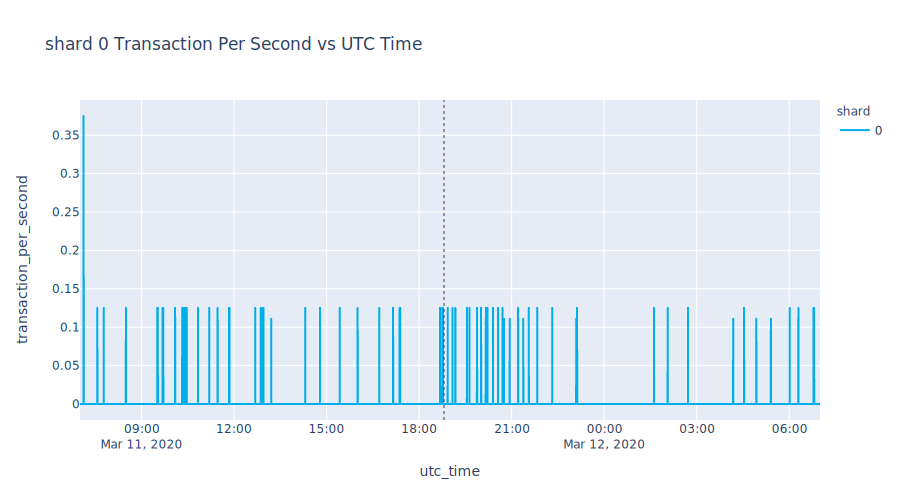

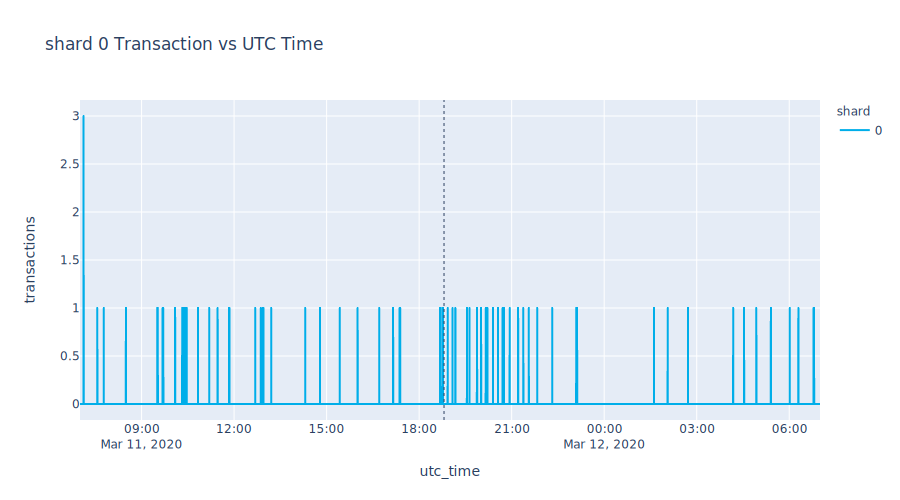

Features vs Block Height Graphs for shard 0
PNG saved in ../../graphs/test_logs/mainnet_03_11/png/


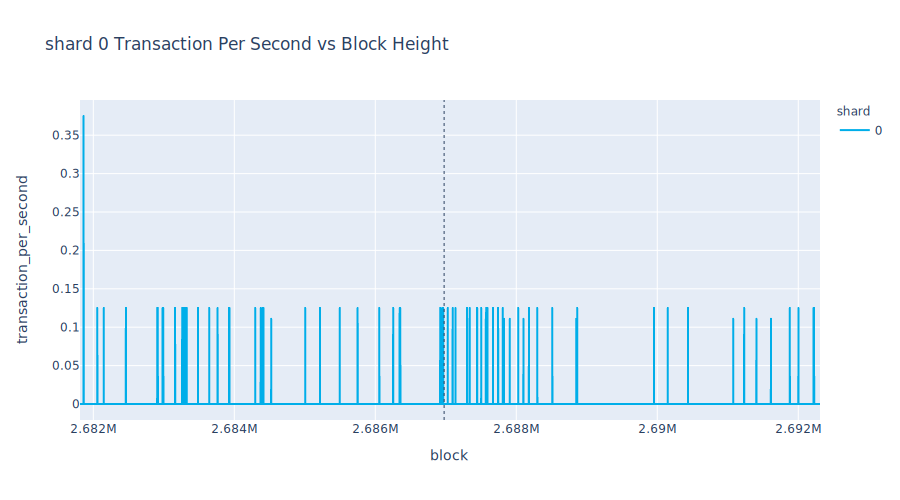

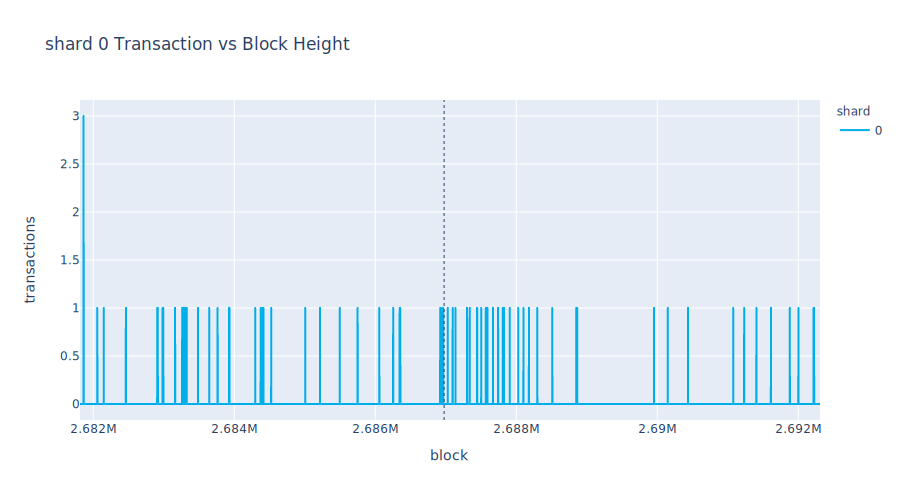

Statistics summary for shard 1
Total data points: 10592
      transactions  transaction_per_second
mean      0.000189                0.000024
std       0.013741                0.001718
min       0.000000                0.000000
25%       0.000000                0.000000
50%       0.000000                0.000000
75%       0.000000                0.000000
max       1.000000                0.125000

Features vs UTC Time Graphs for shard 1
PNG saved in ../../graphs/test_logs/mainnet_03_11/png/


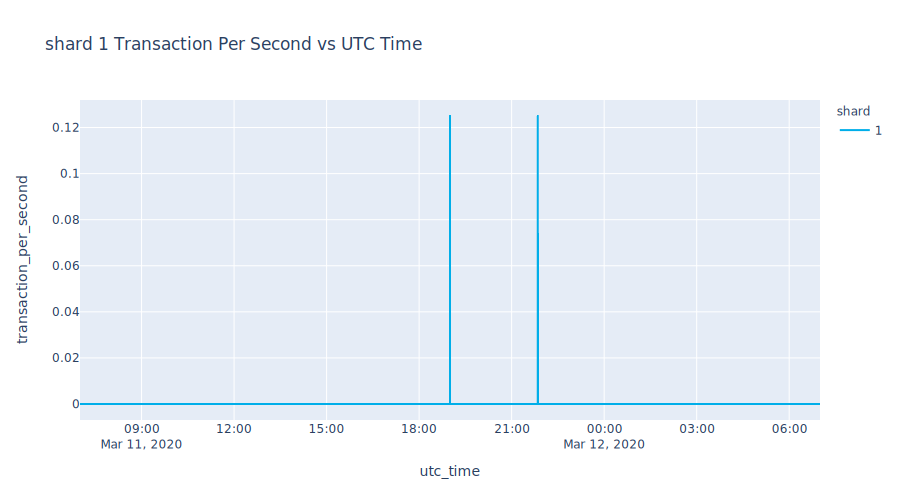

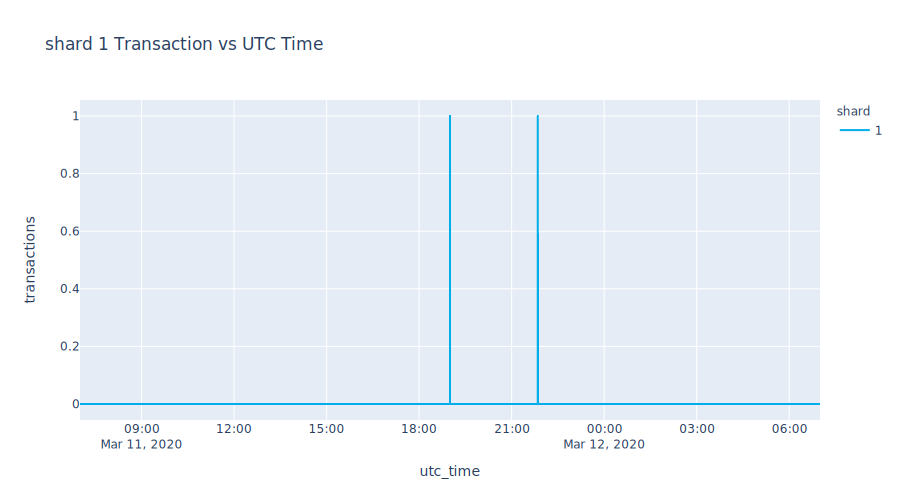

Features vs Block Height Graphs for shard 1
PNG saved in ../../graphs/test_logs/mainnet_03_11/png/


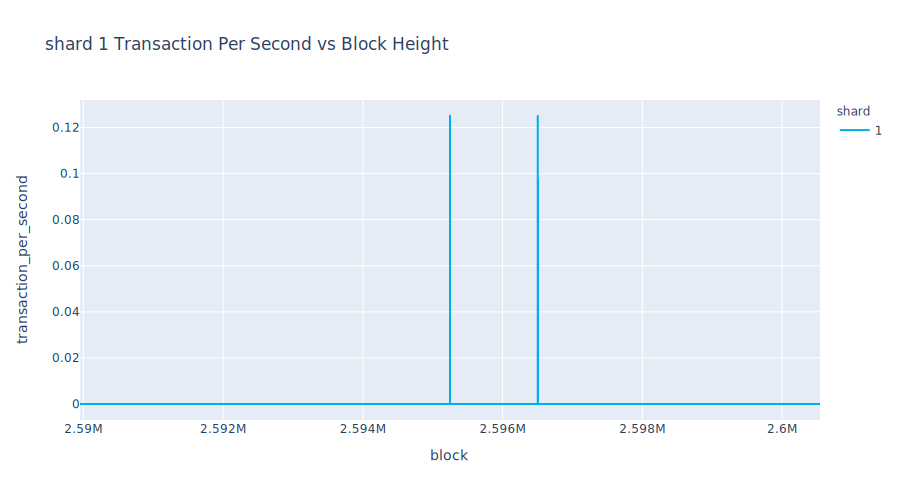

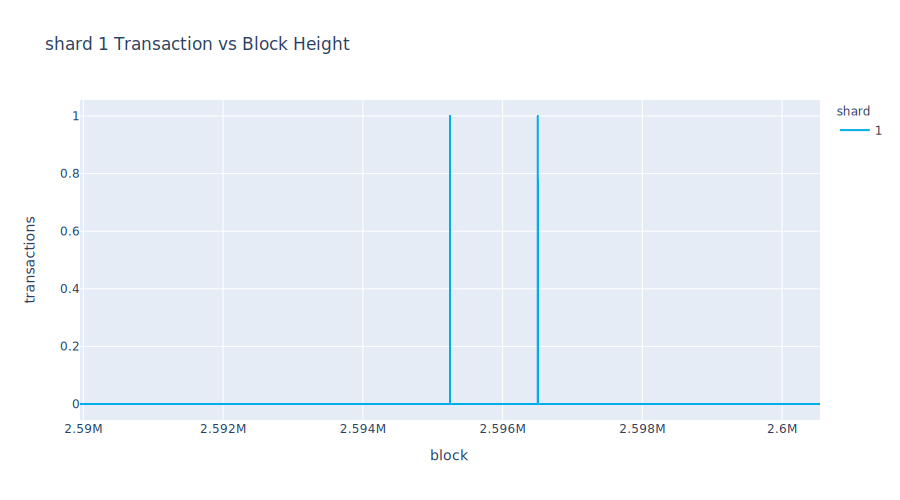

Statistics summary for shard 2
Total data points: 10573
      transactions  transaction_per_second
mean      0.000189                0.000021
std       0.013753                0.001528
min       0.000000                0.000000
25%       0.000000                0.000000
50%       0.000000                0.000000
75%       0.000000                0.000000
max       1.000000                0.111111

Features vs UTC Time Graphs for shard 2
PNG saved in ../../graphs/test_logs/mainnet_03_11/png/


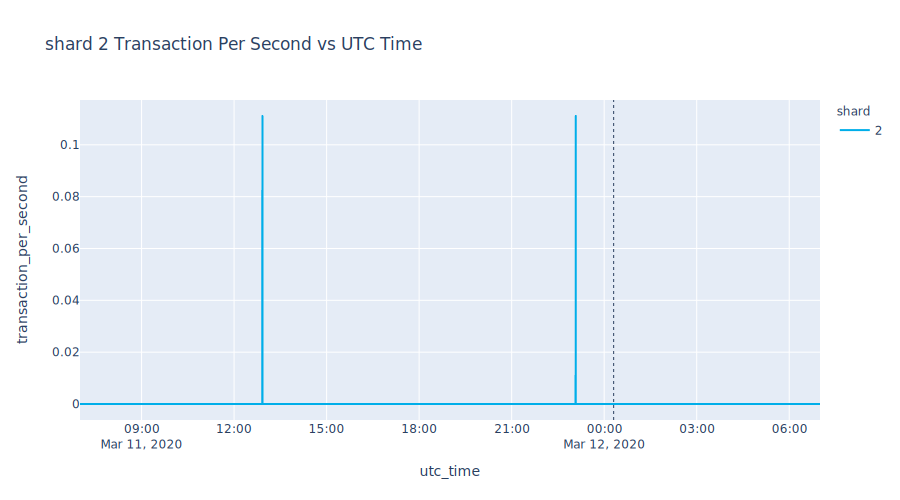

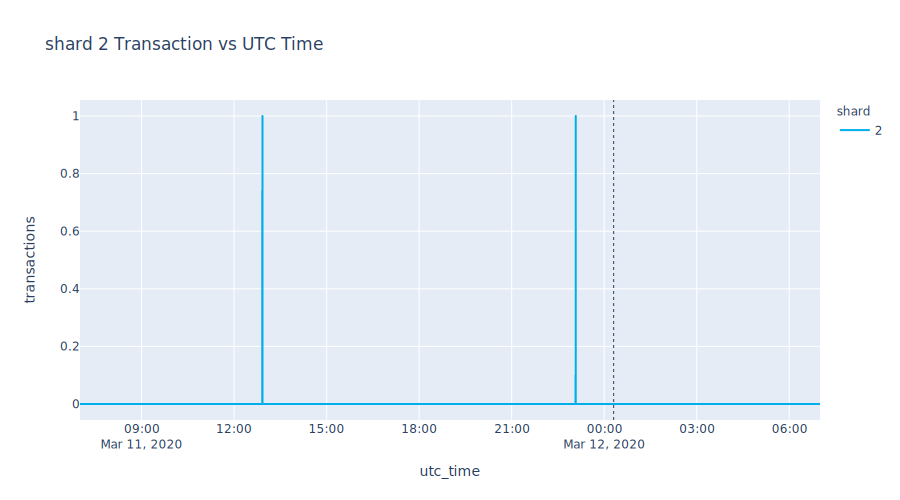

Features vs Block Height Graphs for shard 2
PNG saved in ../../graphs/test_logs/mainnet_03_11/png/


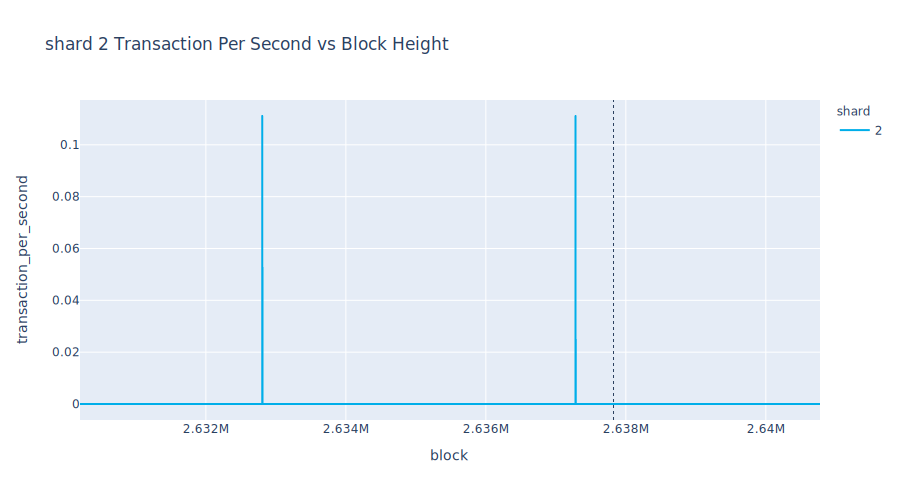

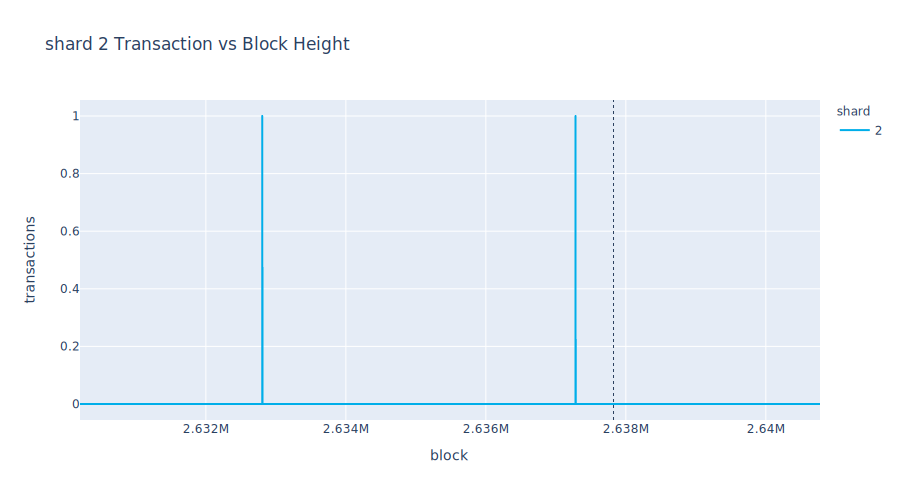

Statistics summary for shard 3
Total data points: 10585
      transactions  transaction_per_second
mean      0.000378                0.000045
std       0.019437                0.002299
min       0.000000                0.000000
25%       0.000000                0.000000
50%       0.000000                0.000000
75%       0.000000                0.000000
max       1.000000                0.125000

Features vs UTC Time Graphs for shard 3
PNG saved in ../../graphs/test_logs/mainnet_03_11/png/


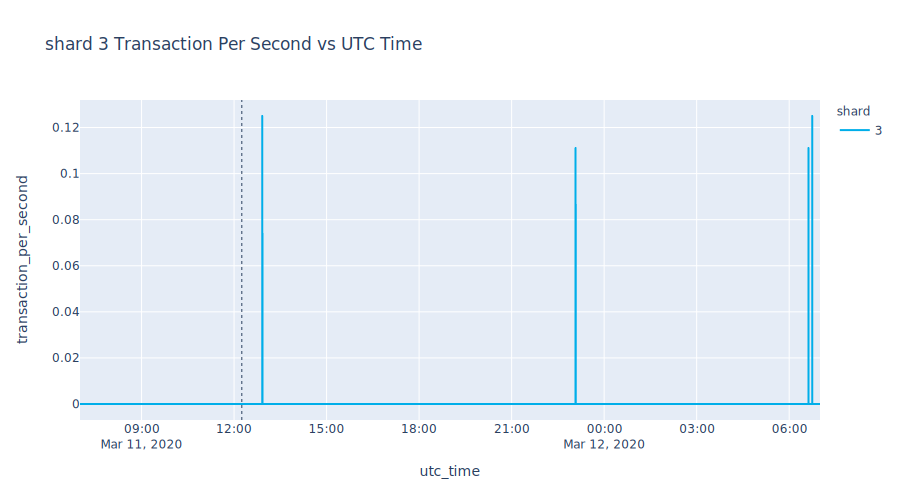

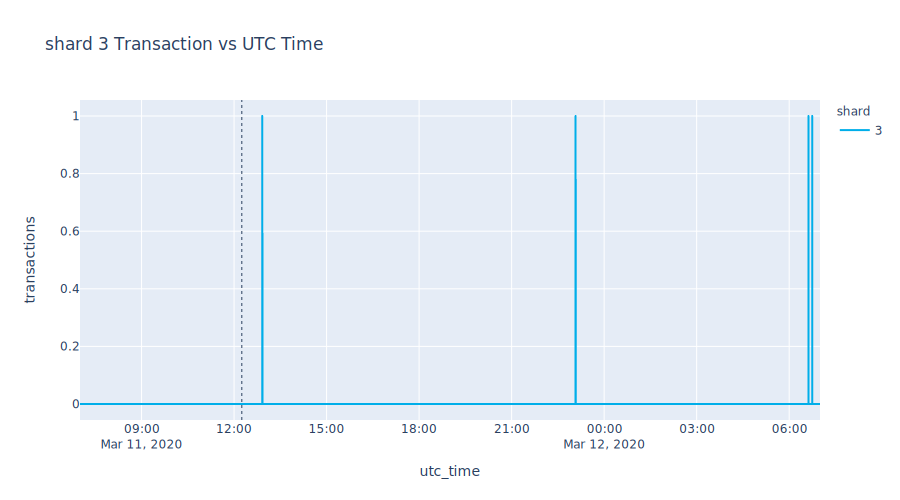

Features vs Block Height Graphs for shard 3
PNG saved in ../../graphs/test_logs/mainnet_03_11/png/


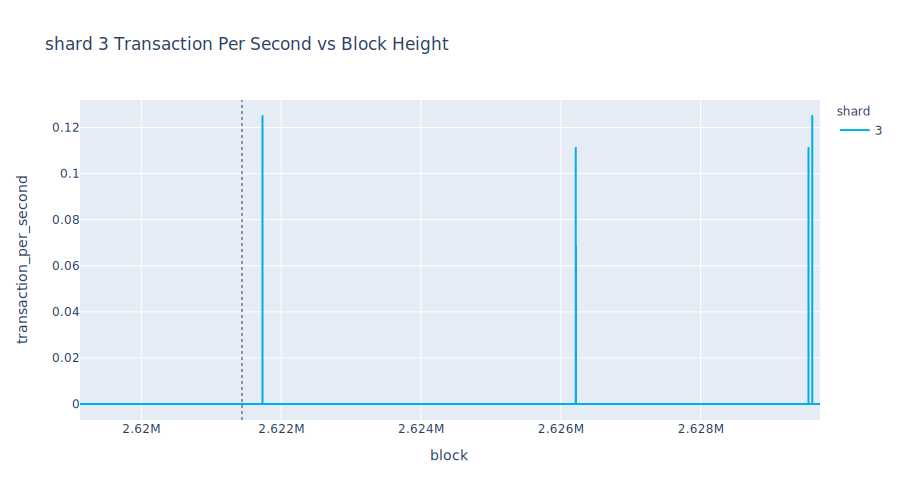

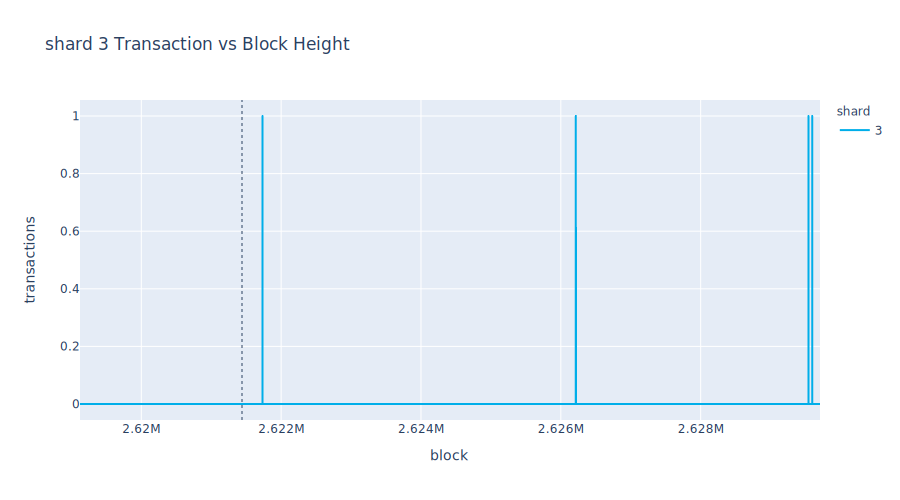

Features vs Time
PNG saved in ../../graphs/test_logs/mainnet_03_11/png/


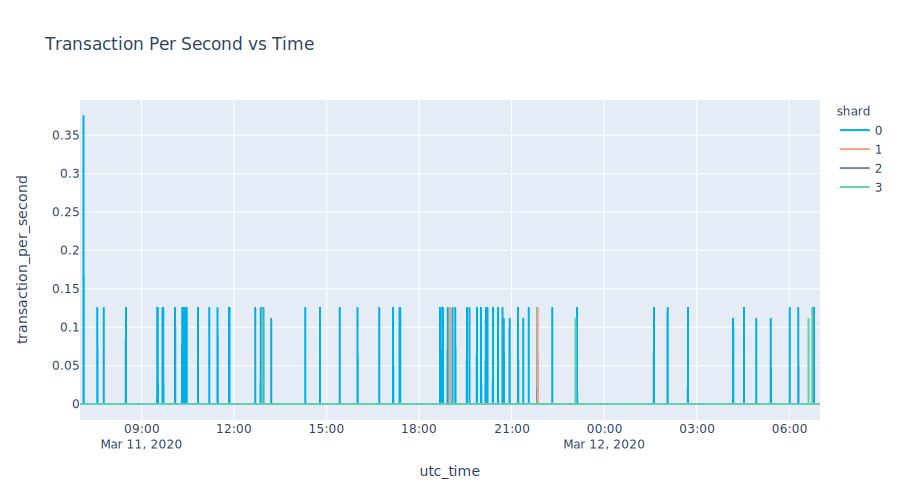

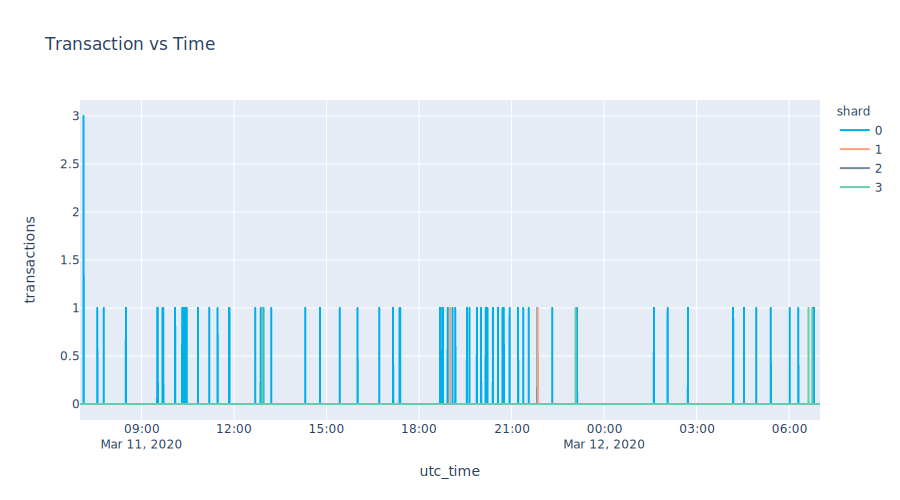

Features vs Block Height
PNG saved in ../../graphs/test_logs/mainnet_03_11/png/


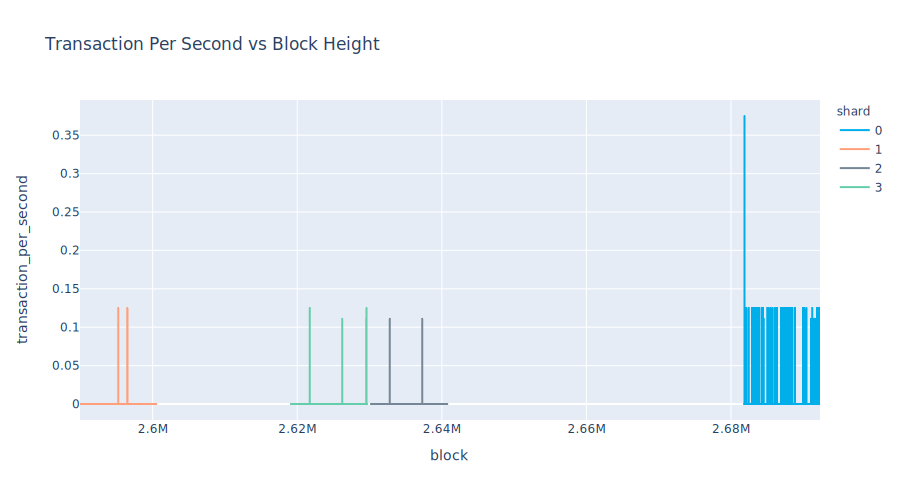

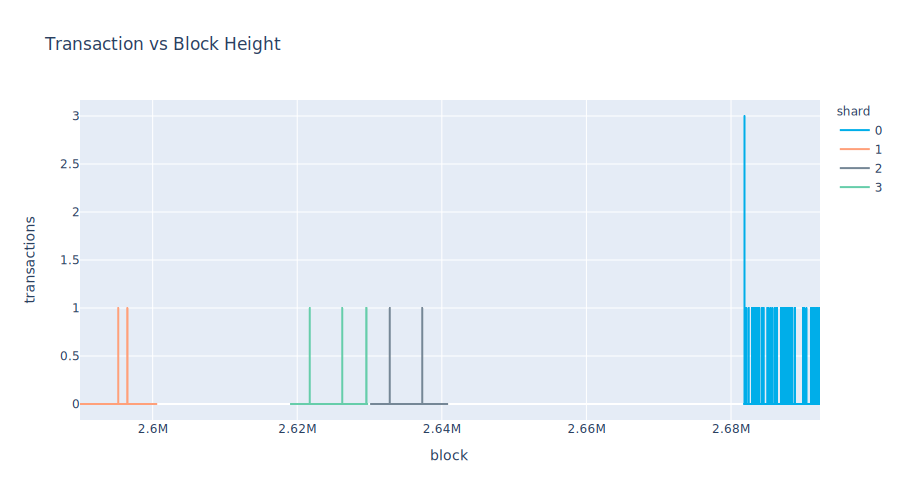

In [12]:
if __name__ == "__main__":

    if os.path.exists(fig_dir):
        shutil.rmtree(fig_dir)
    os.mkdir(fig_dir)
    
    files = os.listdir(log_dir)
    data = read_data(files, log_dir)
    for i in range(len(start_time)):
        shard = data_processing(data, start_time[i], end_time[i])
        colors = colors[:len(shard)]

        new = pd.concat(shard)
        print(new['transactions'].sum())
        
    new.reset_index(inplace = True, drop = True)
    visualization(new, fig_dir)
   